 Andrew J Markland, ajm259@uakron.edu\
 The University of Akron, CEPS, School of Computer Science\
 Applied Machine Learning CPSC-436-010\
 Dr. Zhong-Hui Duan\

# Project 1, kNN
 -Project Scope:\
     Apply the machine learning classification algorithm "k nearest neighbors"(kNN) to correctly classify a dataset of people based on their risk for MI, Myocardial Infarction.  

In [184]:
#imports, decided to keep that at the top to keep them global 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
import random


avg accuracy: 0.7524044794362854

median accuracy: 0.7557399262278335

highest accuracy: 0.8293515358361775

Lowest accuracy: 0.6618181818181819

accuracy range: 16.753335401799564%


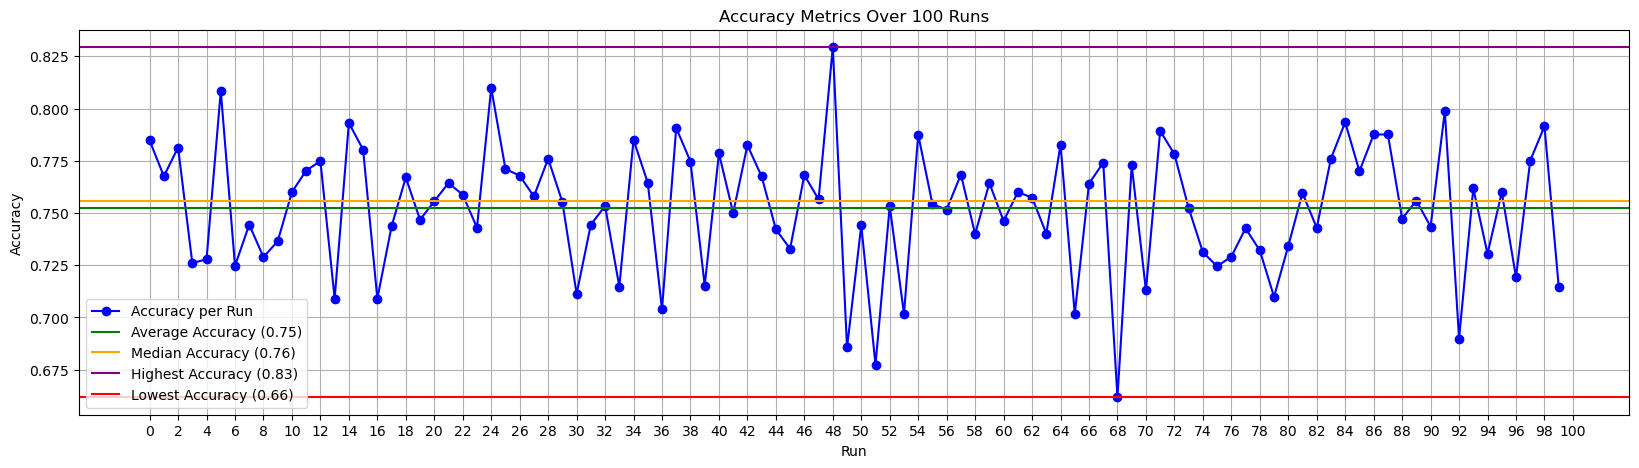

In [194]:
avgList = pd.DataFrame(columns = ['run', 'avg']).set_index('run')
for x in range(100):
    people_df = pd.read_csv("NHANES_data_train.csv")
    
#partitioning random test data and and training data
    trainDf, testDf = train_test_split(people_df, test_size = 0.2, random_state = None)
    
#Get counts of persons with MI and noMI
    MIcount = (trainDf["MI"] == 1).sum()
    noMIcount = (trainDf["MI"] == 2).sum()
    testMIcount = (testDf["MI"] == 1).sum()
    testnoMIcount = (testDf["MI"] == 2).sum()
#Isolate the same number of NoMI's as the MI subgroup
    dirtyTrainMI_sample = trainDf[trainDf["MI"] == 1]
    cleanTrainNoMISample = ((trainDf[trainDf["MI"] == 2]).dropna())
    noMIcount = (cleanTrainNoMISample["MI"] == 2).sum()
    cleanTrainNoMISample = cleanTrainNoMISample.sample(frac=(MIcount/noMIcount))
    
    dirtyTestMI_sample = testDf[testDf["MI"] == 1]
    cleanTestNoMISample = ((testDf[testDf["MI"] == 2]).dropna())
    

#Declare imputer object and clean the data
    imputer = KNNImputer(n_neighbors = 7)
    
    crudeCleanTrainMI = imputer.fit_transform(dirtyTrainMI_sample)
    cleanTrainMI = pd.DataFrame(crudeCleanTrainMI, columns = dirtyTrainMI_sample.columns)

    crudeCleanTestMI = imputer.fit_transform(dirtyTestMI_sample)
    cleanTestMI = pd.DataFrame(crudeCleanTestMI, columns = dirtyTestMI_sample.columns)

    
#fTrainSample is the final sample group to train the KNN model on, comprising the same number of
    #people with MI's and people without MI's and on a random scale
    fTrainSample = (pd.concat([cleanTrainMI, cleanTrainNoMISample])).sample(frac=1)
    fTestSample = (pd.concat([cleanTestMI, cleanTestNoMISample])).sample(frac=1)
    
##---------------------------------------------------------- break in data acquisition ---------------------------------------------------------------
    # metric='manhattan'
    knn = KNeighborsClassifier(n_neighbors = 21 , metric='minkowski', p= 2)
    scaler = StandardScaler()
    
#weights for scalaing attribute importance
    # 1:ID, 2:income, 3:sex, 4:age 5:race, 6:edu, 7:dist, 8:syst, 9:pulse, 10:BMI, 11:HDL 12:trig, 13:LDL, 14:TChol, 15:Kidney, 16:diabetes, 17:smoke, 
    # 18:active, 19:insured
    #                    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18   19
    weights = np.array([0.5, 0.5, 1.5, 0.5, 0.4, 1.5, 1.0, 1.5, 1.3, 2.0, 1.0, 1.0, 2.5, 1.0, 1.0, 1.5, 1.0, 1.0])
    nuetral_weights = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

    #weights = np.array([-3.172965903918653, -0.8010663465504235, 3.0450351108444424, -0.02878732771142829, 0.3816059569759385, -1.0351799683289684, 1.0756525148165101, 1.3490278097256223, -0.3034617603058034, 4.772431682210611, -2.2050538610567405, 0.7772370786927548, 5.102391158129435, 0.36682340903340444, -2.233282190307123, -1.410461449702674, 2.2696613859048753, 1.901206249919593])

#Prepping the training data to train the model
    wipeIdTrainDF = fTrainSample.drop("ParticipantID", axis=1)
    trainIDs = fTrainSample["ParticipantID"]
    wipeIdTestDF = fTestSample.drop("ParticipantID", axis=1)
    testIDs = fTestSample["ParticipantID"]
    
    x_train = scaler.fit_transform(wipeIdTrainDF.drop("MI", axis=1))  * weights
    #x_train = scaler.fit_transform(wipeIdTrainDF.drop("MI", axis=1))  * nuetral_weights
    y_train = wipeIdTrainDF["MI"]
    knn.fit(x_train, y_train)

#prepping the test data to check the model
    x_test = scaler.transform(wipeIdTestDF.drop("MI", axis=1))  * weights
    #x_test = scaler.transform(wipeIdTestDF.drop("MI", axis=1))  * nuetral_weights
    y_test = fTestSample["MI"]
    
#testing the model
    predictions = knn.predict(x_test)
    
#logging accuracy to check the model
    accuracy = accuracy_score(y_test, predictions)
    #print(f"Model accuracy: {accuracy}")
    avgList.loc[x, 'avg'] = accuracy

##------------------------------------------------------------ break in data analysis -----------------------------------------------------------------

print("avg accuracy: " + str(avgList['avg'].mean()) + '\n')
print("median accuracy: " + str(avgList['avg'].median()) + '\n')
print("highest accuracy: " + str(avgList['avg'].max()) + '\n')
print("Lowest accuracy: " + str(avgList['avg'].min()) + '\n')
print("accuracy range: " + str((avgList['avg'].max() - avgList['avg'].min()) * 100) + '%\n')


# Plotting the accuracy values
plt.figure(figsize=(20, 5))  # Set the figure size
plt.plot(avgList.index, avgList['avg'], label='Accuracy per Run', marker='o', linestyle='-', color='blue')

# Calculating the statistics
average_accuracy = avgList['avg'].mean()
median_accuracy = avgList['avg'].median()
highest_accuracy = avgList['avg'].max()
lowest_accuracy = avgList['avg'].min()

# Adding lines for average, median, highest, and lowest
plt.axhline(y=average_accuracy, color='green', linestyle='-', label=f'Average Accuracy ({average_accuracy:.2f})')
plt.axhline(y=median_accuracy, color='orange', linestyle='-', label=f'Median Accuracy ({median_accuracy:.2f})')
plt.axhline(y=highest_accuracy, color='purple', linestyle='-', label=f'Highest Accuracy ({highest_accuracy:.2f})')
plt.axhline(y=lowest_accuracy, color='red', linestyle='-', label=f'Lowest Accuracy ({lowest_accuracy:.2f})')

plt.legend()
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Accuracy Metrics Over 100 Runs')
plt.xticks(range(0, 101, 2))  # Adjust x-axis ticks if necessary
plt.grid(True)  # Adds a grid for better readability

plt.show()


In [92]:

        trainDf, testDf = train_test_split(people_df, test_size = 0.2, random_state = None)
    
    #Get counts of persons with MI and noMI
        MIcount = (trainDf["MI"] == 1).sum()
        noMIcount = (trainDf["MI"] == 2).sum()
        testMIcount = (testDf["MI"] == 1).sum()
        testnoMIcount = (testDf["MI"] == 2).sum()
    #Isolate the same number of NoMI's as the MI subgroup
        dirtyTrainMI_sample = trainDf[trainDf["MI"] == 1]
        cleanTrainNoMISample = ((trainDf[trainDf["MI"] == 2]).dropna())
        noMIcount = (cleanTrainNoMISample["MI"] == 2).sum()
        cleanTrainNoMISample = cleanTrainNoMISample.sample(frac=(MIcount/noMIcount))
    
        dirtyTestMI_sample = testDf[testDf["MI"] == 1]
        cleanTestNoMISample = ((testDf[testDf["MI"] == 2]).dropna())
    

    #Declare imputer object and clean the data
        imputer = KNNImputer(n_neighbors = 9)
    
        crudeCleanTrainMI = imputer.fit_transform(dirtyTrainMI_sample)
        cleanTrainMI = pd.DataFrame(crudeCleanTrainMI, columns = dirtyTrainMI_sample.columns)

        crudeCleanTestMI = imputer.fit_transform(dirtyTestMI_sample)
        cleanTestMI = pd.DataFrame(crudeCleanTestMI, columns = dirtyTestMI_sample.columns)

    
    #fTrainSample is the final sample group to train the KNN model on, comprising the same number of
        #people with MI's and people without MI's and on a random scale
        fTrainSample = (pd.concat([cleanTrainMI, cleanTrainNoMISample])).sample(frac=1)
        fTestSample = (pd.concat([cleanTestMI, cleanTestNoMISample])).sample(frac=1)
        
        wipeIdTrainDF = fTrainSample.drop("ParticipantID", axis=1)
        trainIDs = fTrainSample["ParticipantID"]
        wipeIdTestDF = fTestSample.drop("ParticipantID", axis=1)
        testIDs = fTestSample["ParticipantID"]


In [164]:
weights = np.array([0.5393297782207249, 0.30020427143435524, 1.9959176972459907, 0.47403172306657443, -0.05523335175329882, 1.482665341289769, 0.8358161524846103, 1.8762907996941993, 0.7880324278864782, 1.5766277345106707, 0.5696042546076882, 1.0699527358214653, 2.602715402898512, 1.4845637806211542, 1.3988529513106358, 1.9413567662124, 1.6563822470097622, 0.601963792074643])
#weights = np.ones(18)
learning_rate = 0.01
epsilon = 0.1  # Exploration rate
gamma = 0.5  # Discount factor
best_accuracy = 0.0
for episode in range(10000):
    if random.uniform(0, 1) < epsilon:
        weights += np.random.uniform(-0.1, 0.1, size=weights.shape)
        #partitioning random test data and and training data
            
        x_train = scaler.fit_transform(wipeIdTrainDF.drop("MI", axis=1))  * weights
        y_train = wipeIdTrainDF["MI"]
        knn.fit(x_train, y_train)

    #prepping the test data to check the model
        x_test = scaler.transform(wipeIdTestDF.drop("MI", axis=1))  * weights
        y_test = fTestSample["MI"]
    
    #testing the model
        predictions = knn.predict(x_test)
    
    #logging accuracy to check the model
        accuracy = accuracy_score(y_test, predictions)
        
        reward = accuracy - best_accuracy
        
        if reward > 0:
            best_accuracy = accuracy  # Update best accuracy if improved
            # Adjust weights slightly towards current weights
            weights += learning_rate * reward * np.random.uniform(0.9, 1.1, size=weights.shape)
        else:
            # Adjust weights slightly away from current weights
            weights -= learning_rate * np.abs(reward) * np.random.uniform(0.9, 1.1, size=weights.shape)
            # Log progress
    print(f"Episode {episode+1}: Accuracy = {accuracy:.4f}, Reward = {reward:.4f}")

# Assuming weights is a NumPy array or a list of weights
print("Optimized weights:", ", ".join([str(weight) for weight in weights]))

Episode 1: Accuracy = 0.7516, Reward = -0.0163
Episode 2: Accuracy = 0.7516, Reward = -0.0163
Episode 3: Accuracy = 0.7516, Reward = -0.0163
Episode 4: Accuracy = 0.7516, Reward = -0.0163
Episode 5: Accuracy = 0.7516, Reward = -0.0163
Episode 6: Accuracy = 0.7516, Reward = -0.0163
Episode 7: Accuracy = 0.7516, Reward = -0.0163
Episode 8: Accuracy = 0.7516, Reward = -0.0163
Episode 9: Accuracy = 0.7516, Reward = -0.0163
Episode 10: Accuracy = 0.7516, Reward = -0.0163
Episode 11: Accuracy = 0.7516, Reward = -0.0163
Episode 12: Accuracy = 0.7516, Reward = -0.0163
Episode 13: Accuracy = 0.7516, Reward = -0.0163
Episode 14: Accuracy = 0.7451, Reward = 0.7451
Episode 15: Accuracy = 0.7451, Reward = 0.7451
Episode 16: Accuracy = 0.7451, Reward = 0.7451
Episode 17: Accuracy = 0.7451, Reward = 0.7451
Episode 18: Accuracy = 0.7451, Reward = 0.7451
Episode 19: Accuracy = 0.7484, Reward = 0.0033
Episode 20: Accuracy = 0.7484, Reward = 0.0033
Episode 21: Accuracy = 0.7484, Reward = 0.0033
Episode 2

In [212]:
#final Run

people_df = pd.read_csv("NHANES_data_train.csv")
test_df = pd.read_csv("NHANES_test_data_4_students.csv")

participantID = test_df["ParticipantID"]
    
#Get counts of persons with MI and noMI
MIcount = (people_df["MI"] == 1).sum()
noMIcount = (people_df["MI"] == 2).sum()

#Isolate the same number of NoMI's as the MI subgroup
dirtyTrainMI_sample = people_df[people_df["MI"] == 1]
cleanTrainNoMISample = ((people_df[people_df["MI"] == 2]).dropna())
noMIcount = (cleanTrainNoMISample["MI"] == 2).sum()
cleanTrainNoMISample = cleanTrainNoMISample.sample(frac=(MIcount/noMIcount))
    
#Declare imputer object and clean the data
imputer = KNNImputer(n_neighbors = 7)

crudeCleanTrainMI = imputer.fit_transform(dirtyTrainMI_sample)
cleanTrainMI = pd.DataFrame(crudeCleanTrainMI, columns = dirtyTrainMI_sample.columns)

crudeCleanTestDf = imputer.fit_transform(test_df)
cleanTestDf = pd.DataFrame(crudeCleanTestDf, columns = test_df.columns)
    
#fTrainSample is the final sample group to train the KNN model on, comprising the same number of
    #people with MI's and people without MI's and on a random scale
fTrainSample = (pd.concat([cleanTrainMI, cleanTrainNoMISample])).sample(frac=1)
    
##---------------------------------------------------------- break in data acquisition ---------------------------------------------------------------
    # metric='manhattan'
knn = KNeighborsClassifier(n_neighbors = 21 , metric='minkowski', p= 2)
scaler = StandardScaler()
    
#weights for scalaing attribute importance
    # 1:ID, 2:income, 3:sex, 4:age 5:race, 6:edu, 7:dist, 8:syst, 9:pulse, 10:BMI, 11:HDL 12:trig, 13:LDL, 14:TChol, 15:Kidney, 16:diabetes, 17:smoke, 
    # 18:active, 19:insured
    #                    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18   19
weights = np.array([0.5, 0.5, 1.5, 0.5, 0.4, 1.5, 1.0, 1.5, 1.3, 2.0, 1.0, 1.0, 2.5, 1.0, 1.0, 1.5, 1.0, 1.0])
nuetral_weights = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

#Prepping the training data to train the model
wipeIdTrainDF = fTrainSample.drop("ParticipantID", axis=1)
trainIDs = fTrainSample["ParticipantID"]
wipeIdTestDF = cleanTestDf.drop("ParticipantID", axis=1)
    
x_train = scaler.fit_transform(wipeIdTrainDF.drop("MI", axis=1))  * weights
#x_train = scaler.fit_transform(wipeIdTrainDF.drop("MI", axis=1))  * nuetral_weights
y_train = wipeIdTrainDF["MI"]

knn.fit(x_train, y_train)

#prepping the test data to check the model
finalTestDf = scaler.fit_transform(wipeIdTestDF) * weights

#testing the model
predictions = knn.predict_proba(finalTestDf)

#creating the final Dataframe to become the CSV
predictions_df = pd.DataFrame(predictions, columns=["No MI", "MI"])
prob_of_MI = predictions_df["MI"]
participantID_df = participantID.to_frame(name = "ParticipantID")
final_sheet = pd.concat([participantID_df, prob_of_MI], axis=1)

#output CSV
final_sheet.to_csv("./Results/knn/knn_pred.csv", index =False)